# Visualizations

In this notebook, we generate several visualizations to look at relationships between health measures and dominant industries, using the merged data set from Notebook 1 (Data Cleaning).

# 1. Imports

In [ ]:
# -- Imports that will be used in this notebook.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tckr
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

from pandas import DataFrame
from pandas.plotting import parallel_coordinates
from math import ceil
from matplotlib import colors, cm, figure
from matplotlib.axes import Axes
from typing import Optional

# 2. Initialization

Initialize constants, utility classes, and common methods that will be used in this notebook.

## 2a. Define Palettes and Font

In [ ]:
# -- Define the palettes that will be used by the visualizations.
PALETTE_CATEGORICAL = 'tab20'
PALETTE_SEQUENTIAL = 'viridis'

# -- Define colors that will be used, subset of viridis palette
VIRIDIS_TEAL = '#21918c'
VIRIDIS_BLUE = '#414487'
TEXT_COLOR = '#757070'

# -- Define font sizes for visualizations
SMALLEST_SIZE =  8
SMALL_SIZE    = 14
MEDIUM_SIZE   = 18
BIGGER_SIZE   = 20
BIGGEST_SIZE  = 25

plt.rc('font', size=SMALLEST_SIZE)       # controls default text sizes   
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title     
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels    
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels    
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize                
plt.rc('legend', title_fontsize=BIGGER_SIZE)
plt.rc('figure', titlesize=BIGGEST_SIZE) # fontsize of the figure title

## 2b. Utility Classes and Methods

In [ ]:
class MetricOfInterest:
    def __init__(self, name: str, col_name: str, *, category: Optional[str] = None, 
                 unit: Optional[str] = None) -> None:
        """This is a utility class for object oriented programming (OOP) best practices
        Parameters:
            name - user friendly name of the metric, used as a label in visualizations
            col_name - corresponding column name for the metric in the dataset
            category [optional] - a category to apply to the metric, may be used for grouping in
                visualizations, defaults to None
            unit [optional] - unit of measurement, used to group visualizations by corresponding
                units, defaults to None
        """
        self.name = name
        self.col_name = col_name
        self.category = category
        self.unit = unit

In [ ]:
# -- Functions for formating Axes objects and plots
def style_axis(ax, *, xlabel: Optional[str]=None, ylabel: Optional[str]=None, 
               title: Optional[str]=None, rotate_xlabels: Optional[bool]=True) -> Axes:
    if rotate_xlabels:
        # -- Rotate the x labels
        ax.tick_params(axis='x', rotation=90) 

    if title:
        # -- Set and style the title
        ax.set_title(title, loc='center', y=1.05) 

    if xlabel:
        # -- Set the x label
        ax.set_xlabel(xlabel, labelpad=15) 

    if ylabel:
        # -- Set the y label
        ax.set_ylabel(ylabel, labelpad=15) 

    # -- Hide unnecessary spines
    ax.spines[['top', 'right']].set_visible(False)

    return ax

def add_subplot_and_style(fig: figure, nrows: int, ncols: int, index: int, 
                          title: Optional[str]=None) -> Axes:
    # -- Add the subplot
    ax = fig.add_subplot(nrows, ncols, index)
    return style_axis(ax, title=title)

def style_one_plot(title: Optional[str]=None) -> Axes:
    # -- Formatting for a single plot
    return add_subplot_and_style(plt.gcf(), 1, 1, 1, title)

def hide_x_label(active_ax: Axes) -> None:
    # -- Hide the x label
    x_label = active_ax.axes.get_xaxis().get_label()
    x_label.set_visible(False)

def hide_y_label(active_ax: Axes) -> None:
    # -- Hide the y label
    y_label = active_ax.axes.get_yaxis().get_label()
    y_label.set_visible(False)

## 2c. Constants

In [ ]:
CLEANED_INPUT_FILENAME = '_merged_ds1_2_chr_cbr_allcounties.csv'

# -- Metrics to use for the County Business Pattern (CBP) data (dataset 2)
METRIC_NUM_EMPLOYEES = MetricOfInterest('Number of Employees', 'emp')
METRIC_ANNUAL_PAYROLL = MetricOfInterest('Annual Payroll', 'ap')
METRIC_NUM_ESTABLISHMENTS = MetricOfInterest('Number of Establishments', 'est')

INDUSTRY_METRICS = [
    METRIC_NUM_EMPLOYEES,
    METRIC_ANNUAL_PAYROLL,
    METRIC_NUM_ESTABLISHMENTS,
]
INDUSTRY_COL_TO_LABEL = {im.col_name: im.name for im in INDUSTRY_METRICS}
INDUSTRY_COLUMNS = [im.col_name for im in INDUSTRY_METRICS]

# Metrics to use for the County Health Rankings (CHR) data (dataset 1)
# -- units:
#    -- pp: rate per 100,000 population
#    -- %: percentage
#    -- n: whole number
METRIC_PCPS = MetricOfInterest('Primary Care Physicians', 'v004_rawvalue', 
                                category='Access to care', unit='pp')
METRIC_DENTAL_PROVIDERS = MetricOfInterest('Dental Health Providers', 'v088_rawvalue', 
                                            category='Access to care', unit='pp')
METRIC_MENTAL_PROVIDERS = MetricOfInterest('Mental Health Providers', 'v062_rawvalue', 
                                            category='Access to care', unit='pp')
METRIC_OTHER_PRIMARY_PROVIDERS = MetricOfInterest('Other Primary Care Providers', 'v131_rawvalue', 
                                                   category='Access to care', unit='pp')
METRIC_UNINSURED = MetricOfInterest('Uninsured', 'v085_rawvalue', category='Access to care', unit='%')
METRIC_EXCESSIVE_DRINKING = MetricOfInterest('Excessive Drinking', 'v049_rawvalue', 
                                              category='Alcohol & Drug Use', unit='%')
METRIC_FREQ_PHYSICAL_DISTRESS = MetricOfInterest('Frequent Physical Distress', 'v144_rawvalue', 
                                                  category='Quality of life', unit='%')
METRIC_POOR_PHYSICAL_DAYS = MetricOfInterest('Poor Physical Health Days', 'v036_rawvalue', 
                                              category='Quality of life', unit='n')
METRIC_FREQ_MENTAL_DISTRESS = MetricOfInterest('Frequent Mental Distress', 'v145_rawvalue', 
                                                category='Quality of life', unit='%')
METRIC_POOR_MENTAL_DAYS = MetricOfInterest('Poor Mental Health Days', 'v042_rawvalue', 
                                            category='Quality of life', unit='n')
METRIC_DIABETES_PREVALENCE = MetricOfInterest('Diabetes Prevalence', 'v060_rawvalue', 
                                               category='Quality of life', unit='%')
METRIC_ADULT_OBESITY = MetricOfInterest('Adult Obesity', 'v011_rawvalue', 
                                         category='Diet and exercise', unit='%')
METRIC_PREVENTABLE_HOSPITAL = MetricOfInterest('Preventable Hospital Stays', 'v005_rawvalue', 
                                                category='Quality of care', unit='pp')
METRIC_LIFE_EXPECTANCY = MetricOfInterest('Life Expectancy', 'v147_rawvalue', 
                                           category='Length of life', unit='n')
METRIC_ACCESS_HEALTHY_FOODS = MetricOfInterest('Limited Access to Healthy Foods', 'v083_rawvalue', 
                                                category='Diet and exercise', unit='%')
METRIC_AIR_POLLUTION = MetricOfInterest('Air Pollution', 'v125_rawvalue', 
                                         category='Air and water quality')  # non standard units, density
METRIC_UNEMPLOYMENT = MetricOfInterest('Unemployment', 'v023_rawvalue', category='Employment', unit='%')
METRIC_TRAFFIC_VOLUME = MetricOfInterest('Traffic Volume', 'v156_rawvalue', 
                                          category='Housing and transit')  # non standard units, volume per meter
METRIC_HOMEOWNERSHIP = MetricOfInterest('Homeownership', 'v153_rawvalue', category='Housing and transit', 
                                         unit='%')
METRIC_BROADBAND_ACCESS = MetricOfInterest('Broadband Access', 'v166_rawvalue', 
                                            category='Housing and transit', unit='%')
METRIC_HOUSING_PROBLEMS = MetricOfInterest('Severe Housing Problems', 'v136_rawvalue', 
                                            category='Housing and transit', unit='%')
METRIC_POPULATION = MetricOfInterest('County Population', 'v051_rawvalue')

HEALTH_METRICS = [
    METRIC_DENTAL_PROVIDERS,
    METRIC_MENTAL_PROVIDERS,
    METRIC_PCPS,
    METRIC_OTHER_PRIMARY_PROVIDERS,
    METRIC_UNINSURED,
    METRIC_AIR_POLLUTION,
    METRIC_EXCESSIVE_DRINKING,
    METRIC_ADULT_OBESITY,
    METRIC_ACCESS_HEALTHY_FOODS,
    METRIC_UNEMPLOYMENT,
    METRIC_BROADBAND_ACCESS,
    METRIC_HOMEOWNERSHIP,
    METRIC_HOUSING_PROBLEMS,
    METRIC_TRAFFIC_VOLUME,
    METRIC_PREVENTABLE_HOSPITAL,
    METRIC_LIFE_EXPECTANCY,
    METRIC_DIABETES_PREVALENCE,
    METRIC_FREQ_MENTAL_DISTRESS,
    METRIC_FREQ_PHYSICAL_DISTRESS,
]
HEALTH_COL_TO_LABEL = {hm.col_name: hm.name for hm in HEALTH_METRICS}
HEALTH_COLUMNS = list(HEALTH_COL_TO_LABEL.keys())
HEALTH_LABELS = list(HEALTH_COL_TO_LABEL.values())

# 3. Data Preparation

In [ ]:
# -- Read in the merged and cleaned data
raw_df = pd.read_csv(CLEANED_INPUT_FILENAME)

We would like to know the contribution of a given industry to a county. For example, for the county of Autauga in Alabama, what percentage of employees work in the Retail Trade industry?  What is the ranking of Retail Industry in Autauga, in terms of number of employees, annual payroll, or number of establishments?

In [ ]:
# -- Calculate and add the percentage and rank that a given industry contributes to a county
for col_name in INDUSTRY_COLUMNS:
    raw_df[f'{col_name} %'] = 100 * raw_df[col_name] / raw_df.groupby('fipscode')[col_name].transform('sum')
    # Use `dense` method for rank, equal values will be given the same rank
    raw_df[f'{col_name} rank'] = raw_df.groupby('fipscode')[col_name].rank('dense', ascending=False).astype('int')

In [ ]:
# -- Create a column with the concatenation of county and state to be used as labels
raw_df['county and state'] = raw_df['county'] + ', ' + raw_df['state']

In [ ]:
# -- Rename some industries to shorten for visualizations
raw_df['Industry Description'] = raw_df['Industry Description'].replace({
    'Agriculture, Forestry, Fishing and Hunting': 'Agriculture',
    'Mining, Quarrying, and Oil and Gas Extraction': 'Natural Resource Extraction',
    'Transportation and Warehousing': 'Transportation',
    'Finance and Insurance': 'Finance',
    'Real Estate and Rental and Leasing': 'Real Estate',
    'Professional, Scientific, and Technical Services': 'Professional Services',
    'Management of Companies and Enterprises': 'Holding Companies',
    'Administrative and Support and Waste Management and Remediation Services': 'Business Support Services',
    'Educational Services': 'Education',
    'Health Care and Social Assistance': 'Health Care',
    'Arts, Entertainment, and Recreation': 'Entertainment',
    'Accommodation and Food Services': 'Hospitality',
    'Information': 'Information Distribution Services'
    })

In [ ]:
# -- Drop industry categories that are not descriptive
# 81---- : Other Services (except Public Administration)
raw_df.drop(raw_df[raw_df['naics'] == '81----'].index, inplace=True)

# 99---- : Industries not classified
raw_df.drop(raw_df[raw_df['naics'] == '99----'].index, inplace=True)

# -- Clean up indices
raw_df.reset_index(inplace=True)
raw_df.drop(columns=['index', 'Unnamed: 0'], inplace=True)

In [ ]:
# -- Create constants from data
industry_codes = raw_df[['naics', 'Industry Description']].drop_duplicates()
industry_codes.set_index('naics', inplace=True)
industry_codes_to_names = industry_codes.to_dict()
# -- Use column name, `Industry Description`, to access the data we want
industry_codes_to_names = industry_codes_to_names['Industry Description']

industry_codes = list(industry_codes_to_names.keys())
industry_names = list(industry_codes_to_names.values())

In [ ]:
# -- Create dummy/indicator variables for industries to use when creating our correlation matrix
for naics, description in industry_codes_to_names.items():
    raw_df.loc[raw_df['naics'] == naics, f'{description} Indicator'] = 1
    raw_df.loc[raw_df['naics'] != naics, f'{description} Indicator'] = 0

Next, we define several methods that will be used by multiple visualizations.

In [ ]:
# -- Return sliced dataframe containing top n industries per county
def slice_top_industries_in_counties(df: DataFrame, max_rank: int, *, 
                                     metric: Optional[str]='emp') -> DataFrame:
    return df[df[f'{metric} rank'] < (max_rank + 1)]

In [ ]:
# -- Return a new dataframe containing the number of counties that has a given industry as one of its
# -- top X industries per industry metric of:
# --    - `emp`: number of employees
# --    - `ap` : annual payroll
# --    - `est`: number of establishments
def num_counties_in_top_industries(df: DataFrame, *, max_rank: Optional[int]=3) -> DataFrame:
    results_df = DataFrame()
    for col_name, label in INDUSTRY_COL_TO_LABEL.items():
        results_df = pd.concat(
            [
                results_df,
                slice_top_industries_in_counties(df, max_rank, metric=col_name).groupby(
                    'Industry Description'
                )['county and state'].nunique().rename(f'num counties by {col_name}')
            ], axis=1
        )

    return results_df.sort_values(
        by='num counties by emp',
        ascending=False
    )

We are interested in industries that are the dominant industry in a minimum number of counties. We refer to this as "thresholding".

In [ ]:
# -- Return a slice the dataframe, thresholding for industries that are in the top X industries 
# -- for a minimum number of counties. For example, we may only want to see industries that are 
# -- one of the top 3 industries with least 20 counties.
def slice_industries_threshold_on_num_counties(df: DataFrame, num_counties: int, *, max_rank: Optional[int]=3, 
                                               industry_metric: Optional[MetricOfInterest]
                                                                    =METRIC_NUM_EMPLOYEES) -> DataFrame:
    # Determine which industries have the threshold amount of counties    
    num_counties_per_industry = num_counties_in_top_industries(raw_df)
    num_counties_per_industry = num_counties_per_industry[
                                    num_counties_per_industry[f'num counties by {industry_metric.col_name}'
                                    ] >= num_counties]

    num_counties_per_industry = num_counties_per_industry.rename_axis('Industry Description').reset_index()

    # Slice for the top industries in counties
    tdf = slice_top_industries_in_counties(df, max_rank)

    # Return only industries meeting the threshold
    return tdf[tdf['Industry Description'].isin(num_counties_per_industry['Industry Description'])]

# 4. Exploratory Data Analysis and Report Visualizations

We begin our exploratory data analysis with visualizations to understand the various data sets we are using.

## 4a. Identifying metric for determining dominant industries (for report)

We investigated three different ways to identify the dominant industry in a county:
* percent of employees in industry
* total annual payroll of industry
* percent of establishments in industry
We looked at the overall distribution of these three metrics across all 18 industry categories and 3007 counties. 

In [ ]:
# -- Return aggregated percentage of metric for top n industries per county 
def agg_perc_top_industries(df: DataFrame, max_rank: int, metric: str) -> DataFrame:
    top_df = slice_top_industries_in_counties(df, max_rank, metric=metric)
    top_df_grp_perc = (top_df.groupby('county and state')[f'{metric} %']
                             .agg({'sum'})
                             .rename(columns={'sum': f'{metric} %'})
    )
    return top_df_grp_perc

In [ ]:
# -- Plot histograms of the industry metrics
def make_industry_metric_histograms(df: DataFrame, title: str, *, num: Optional[int]=None, 
                                    xlim: Optional[int]=100, ylim: Optional[int]=None, 
                                    note: Optional[int]=None) -> None:
    fig, axs = plt.subplots(1, len(INDUSTRY_COLUMNS), figsize=(20, 6))
    tdf = df
    for idx, (col_name, label) in enumerate(INDUSTRY_COL_TO_LABEL.items()):
        active_ax = axs[idx]
        
        # If `num` is included in inputs, get aggregated metrics for top `num` industries
        if num:
            tdf = agg_perc_top_industries(df, num, metric=col_name)
    
        sns.histplot(
            tdf,
            x=f'{col_name} %',
            color=VIRIDIS_BLUE,
            ax=style_axis(active_ax, xlabel=f'Percentage',
                          title=label),
            edgecolor=TEXT_COLOR            
        );
        hide_y_label(active_ax)

        if ylim:
            active_ax.set_ylim(0, ylim)

        # If `note` is included, create a textbox on the plot with `note`
        if all([xlim, ylim, note]):
            x_offset = 1.50
            y_offset = 1.75
            active_ax.text(
                xlim/2*x_offset, ylim/2*y_offset, note)

    fig.suptitle(title, y=1.07)
    fig.supylabel('Count', x=0.07, fontsize=BIGGER_SIZE)
    return fig;

First, we would like to determine what percentage of a county's employment is captured by the top industry for each method (employees, payroll, establishments).

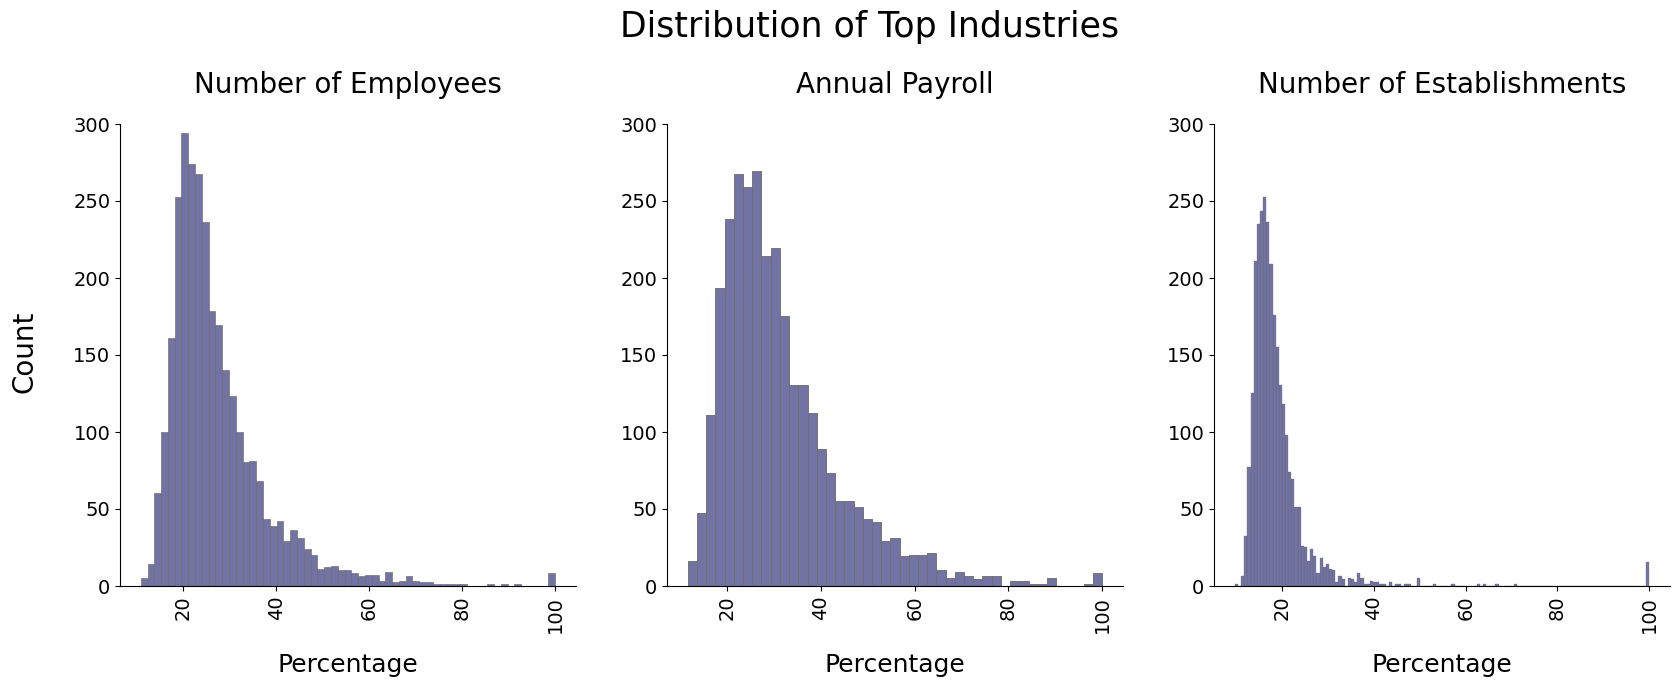

In [ ]:
# -- Histograms of top industries, for all counties
fig = make_industry_metric_histograms(raw_df, 'Distribution of Top Industries', num=1, ylim=300)
fig.show()

Given that the number 1 ranked industry per county does not capture more than 50% of the county's workforce for all three methods, we will next explore distributions where we expand the definition of 'dominant industry' to the top 3 ranked industries per county.

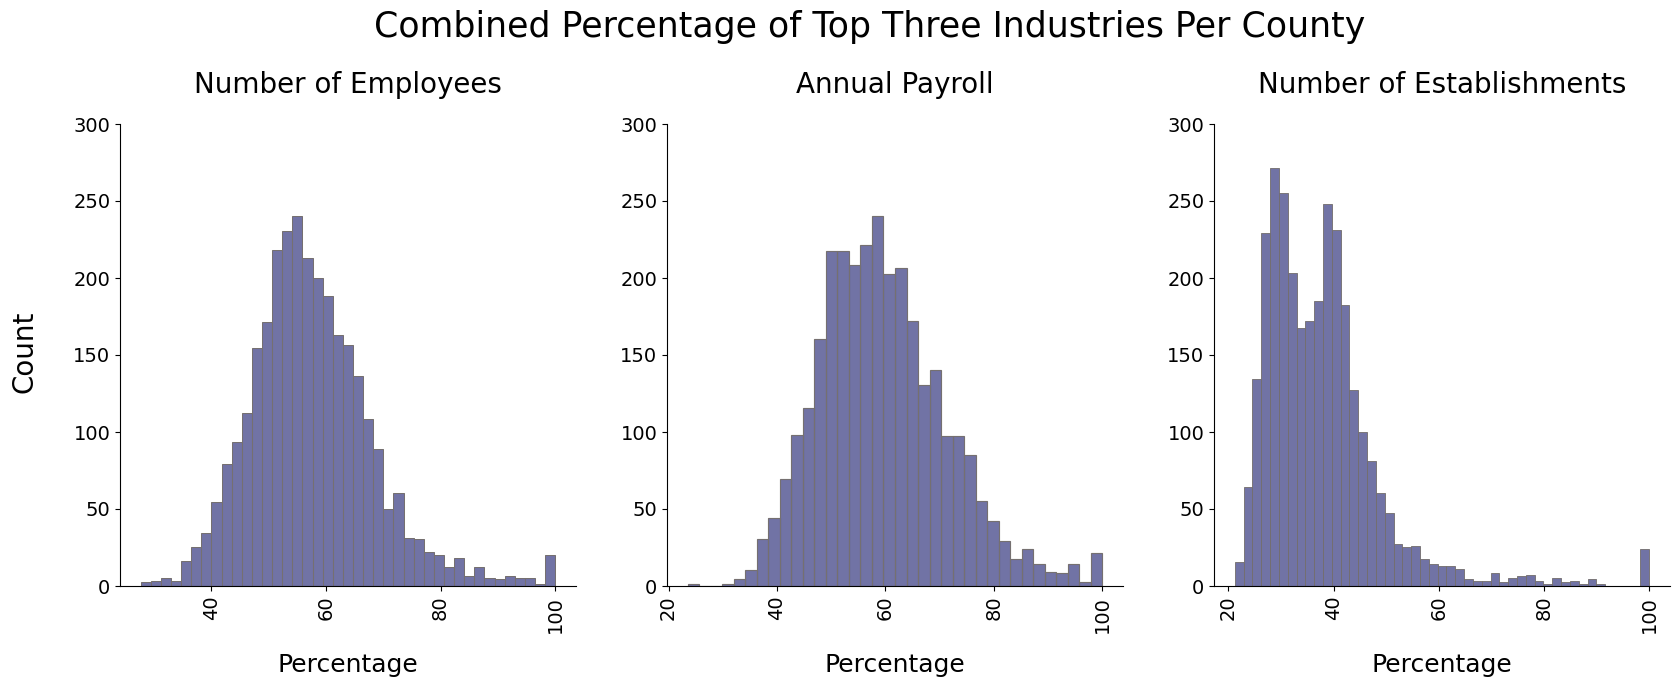

In [ ]:
# -- For comparison, include histogram of top 3 industries per county
fig1_hist = make_industry_metric_histograms(raw_df, 'Combined Percentage of Top Three Industries Per County', 
                                            num=3, ylim=300)
fig1_hist.savefig('Fig1_hist_top3ind.png', bbox_inches='tight')

When we look at the top 3 industries per county instead of the top 1, we see the distributions cover a greater proportion of counties (40-80% for employees and payroll, 20-60% for establishments).

## 4b. Distribution of dominant industries (for report)

For this section, we are looking at the number of counties that include industry categories in their top three, in terms of one of the metrics discussed in the previous section.

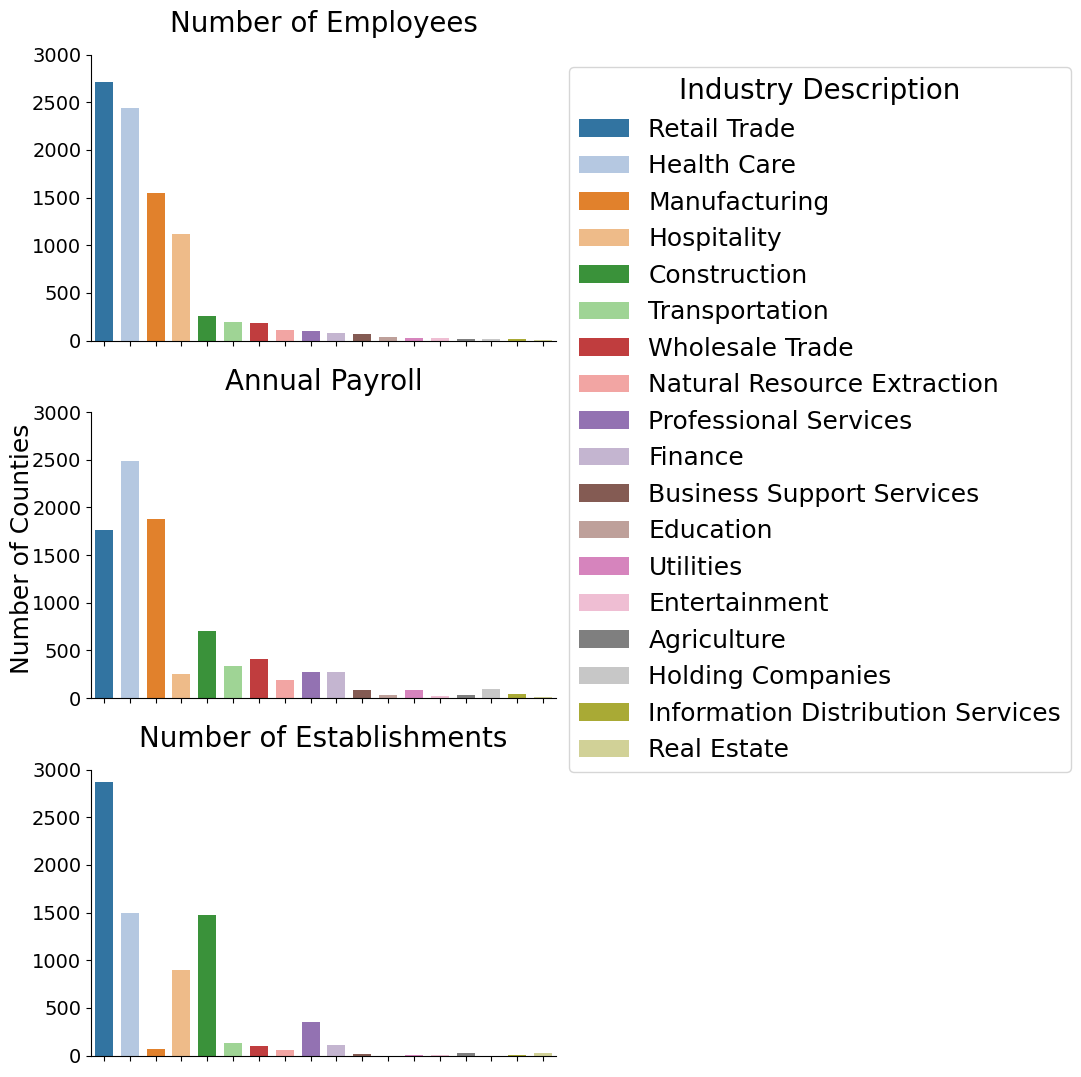

In [ ]:
# -- Plot bar graphs showing number of counties with each category in their top 3, for each metric
fig, axs = plt.subplots(3, 1, figsize=(6,13), sharey=True)

for idx, (col_name, label) in enumerate(INDUSTRY_COL_TO_LABEL.items()):
    active_ax = axs[idx]
    tdf = num_counties_in_top_industries(raw_df).rename_axis('Industry Description').reset_index()
    
    sns.barplot(
        tdf,
        x='Industry Description',
        y=f'num counties by {col_name}',
        palette=PALETTE_CATEGORICAL,
        ax=style_axis(active_ax, title=label),
        label=tdf['Industry Description'],
        width=0.7
    )
    ylim = 3000
    active_ax.set_ylim(0, ylim)
    active_ax.set(xticklabels=[])
    hide_x_label(active_ax)
    hide_y_label(active_ax)

    # Add legend to first subplot
    if idx==0:
        active_ax.legend(title='Industry Description', loc='upper left', bbox_to_anchor=(1, 1))

fig.supylabel('Number of Counties', x=-0.01, fontsize=MEDIUM_SIZE)
plt.subplots_adjust(hspace = 0.25)

fig.savefig('Fig2_bar_top3ind_vert_legend.png', bbox_inches='tight');
plt.show()

When we look at the distribution of counties by their top three industries, we generally observe the same top 2-3 industries with the most counties (retail trade, health care, manufacturing). 

The distribution of counties for top industry by 'number of establishments' is significantly different from the other two, so we will not use this method for selecting top industries. We ultimately decided to use 'number of employees' as our standard metric for determine top industries, as it is more representative of county employment than annual payroll.

Looking at the distributions, we realized some of the industries have a very small number. We decided to threshold further analysis to industries that are dominant in at least 20 counties. Moving forward, we will be using thresholded data, with at least 20 counties per dominant industry.

## 4c. Distribution of county business profile noise flags

The county business metrics include a noise flag in order to anonymize county data. They fall under one of the following categories:
* G: 0% < 2% noise _(low noise)_
* H: 2% < 5% noise _(medium noise)_
* J: >= 5% noise _(high noise)_

We want to confirm that the inclusion of noise flags does not significantly affect our selection of each county's top industries. We plotted the number of top industries (by rank in county) that have low, medium, and high noise. We only compared the 'employee' and 'annual payroll' methods, since there were no noise flags for 'establishments'. 

In [ ]:
noise_flag_to_label = {
    'G': 'Low Noise',
    'H': 'Medium Noise',
    'J': 'High Noise'
}

noise_labels = noise_flag_to_label.values()

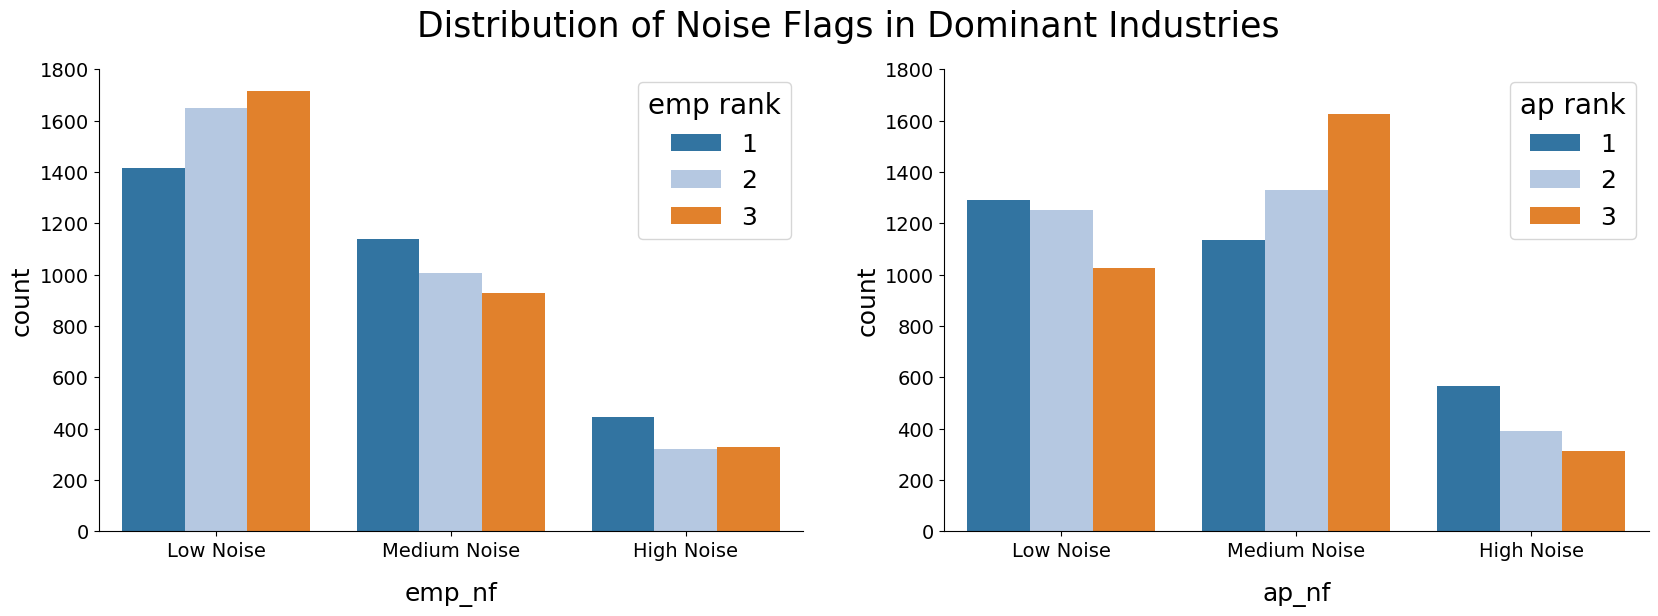

In [ ]:
# -- Plot histograms of the industry metric noise flags in dominant industries
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
df = raw_df
for idx, (col_name, label) in enumerate(INDUSTRY_COL_TO_LABEL.items()):
    if col_name == 'est':
        # There is no noise flag for establishments
        continue

    tdf = slice_top_industries_in_counties(df, 3, metric=col_name)

    active_ax = axs[idx]
    ax = sns.countplot(
        tdf,
        x=f'{col_name}_nf',
        hue=f'{col_name} rank',
        palette=PALETTE_CATEGORICAL,
        ax=style_axis(active_ax, xlabel=f'{label} Noise Flag', rotate_xlabels=False)
    )
    ax.set_xticks(np.arange(len(noise_labels)), noise_labels)
    # Value to set ylim determined visually
    ax.set_ylim(0, 1800)

fig.suptitle('Distribution of Noise Flags in Dominant Industries')

plt.show()

Given that the high noise flags do not represent a significant portion of the data, and that the use of them are for ethical reasons, we have decided to make note of the presence of noise but not alter the data further.

## 4d. Distribution of 'NA' values for health measures

We also wanted to confirm that the number of counties with missing values in the health measures columns is low, and will not significantly affect our correlation calculations between dominant industry and health measures.

In [ ]:
# set figure size for following visualizations
plt.rcParams['figure.figsize'] = [15,6]

In [ ]:
# -- Returns a new data frame that has the total count of `isnull()` values per health metric
def count_na_health_metrics(df: DataFrame, *, county_threshold: Optional[int]=1, 
                                              max_rank: Optional[int]=200) -> DataFrame:
    sliced_df = slice_industries_threshold_on_num_counties(df, county_threshold, max_rank=max_rank)
    
    # Get the names of the health columns
    health_cols = sliced_df.filter(regex='_rawvalue$').columns.tolist()

    # Create a new dataframe with the count of `isnull()` for each health metric
    tdf = DataFrame()
    tdf['count'] = sliced_df.isnull()[health_cols].sum()
    # Divide by the total number of counties
    tdf['count'] = tdf['count']/3007 * 100
    tdf = tdf[tdf['count'] > 0]
    tdf = tdf.reset_index()
  
    return tdf

# -- Returns a bar plot showing percent NAs in health metrics
def make_na_distribution(df: DataFrame, *, county_threshold: Optional[int]=1, 
                         max_rank: Optional[int]=200) -> Axes:  
    # Get dataframe of percentage of NA values for industries health metrics
    tdf = count_na_health_metrics(df, county_threshold=county_threshold, 
                                                    max_rank=max_rank)

    tdf['index'] = tdf['index'].map(HEALTH_COL_TO_LABEL)
    tdf = tdf.rename(columns={'index': 'health measures'})

    ax = sns.barplot(
        tdf,
        x=tdf['count'],
        y=tdf['health measures'],
        errorbar=None,
        orient='h'
    )

    # Display the values for each bar
    for container in ax.containers:
        ax.bar_label(
            container,
            fmt='%.2f%%',
            padding=5,
            fontsize=SMALL_SIZE,
        )

    # Apply our styling without rotation
    style_axis(ax, rotate_xlabels=False)

    return ax

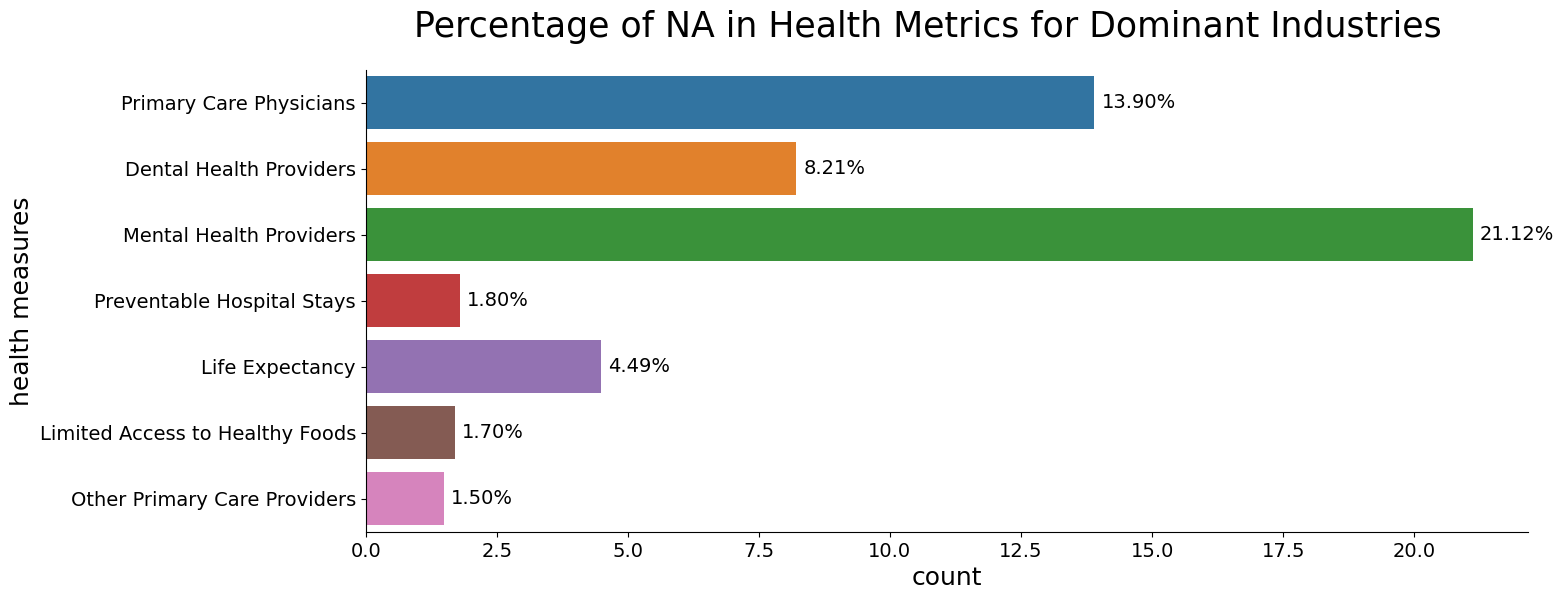

In [ ]:
ax = make_na_distribution(raw_df, county_threshold=20, max_rank=3)
fig = ax.get_figure()
fig.suptitle('Percentage of NA in Health Metrics for Dominant Industries');
fig.show()

This graph only shows metrics with at least 1 NA value. All metrics have less than 25% missing values. The missing data may be coming from small counties. We chose not to drop the NA values, since imputing values does not make sense for this use case. We believe the presence of NA values should not significantly affect our subsequent analysis.

## 4e. Correlation of industry to health measures (for report)

We will now explore the relationships between dominant industries and health measures. First, we will generate correlation coefficients between the selected health measures and all dominant industries (using a dummy/indicator variable that indicates presence of top industry in a county).

In [ ]:
# -- Return a correlation dataframe using the industry indicators and health measures
def corr_industry_with_health_measures(df: DataFrame, max_rank: int, *, 
                                       county_threshold: Optional[int]=None) -> DataFrame:
    # Slice the dataframe - with optional threshold for minimum number of counties per industry
    if county_threshold:
        sliced_df = slice_industries_threshold_on_num_counties(df, county_threshold, max_rank=max_rank)
    else:
        sliced_df = slice_top_industries_in_counties(df, max_rank)

    # Add indicator variables for top industries in our slice
    industry_indicator_cols = [f'{d} Indicator' for d in sliced_df['Industry Description'].drop_duplicates()]
    industry_indicator_cols.sort()

    # Initialize correlation columns with the health measures
    corr_cols = HEALTH_COLUMNS.copy()
    corr_cols.extend(industry_indicator_cols)

    corr = sliced_df[corr_cols].corr().round(3)
    corr = corr[industry_indicator_cols]

    # Rename the index to health measure label
    corr = corr.rename(index=HEALTH_COL_TO_LABEL)

    # Rename the columns to drop superfluous string
    rename_cols = dict()
    for col_name in corr.columns.tolist():
        rename_cols[col_name] = col_name.replace(' Indicator', '')
    corr = corr.rename(columns=rename_cols)

    return corr.iloc[:len(HEALTH_COLUMNS)]

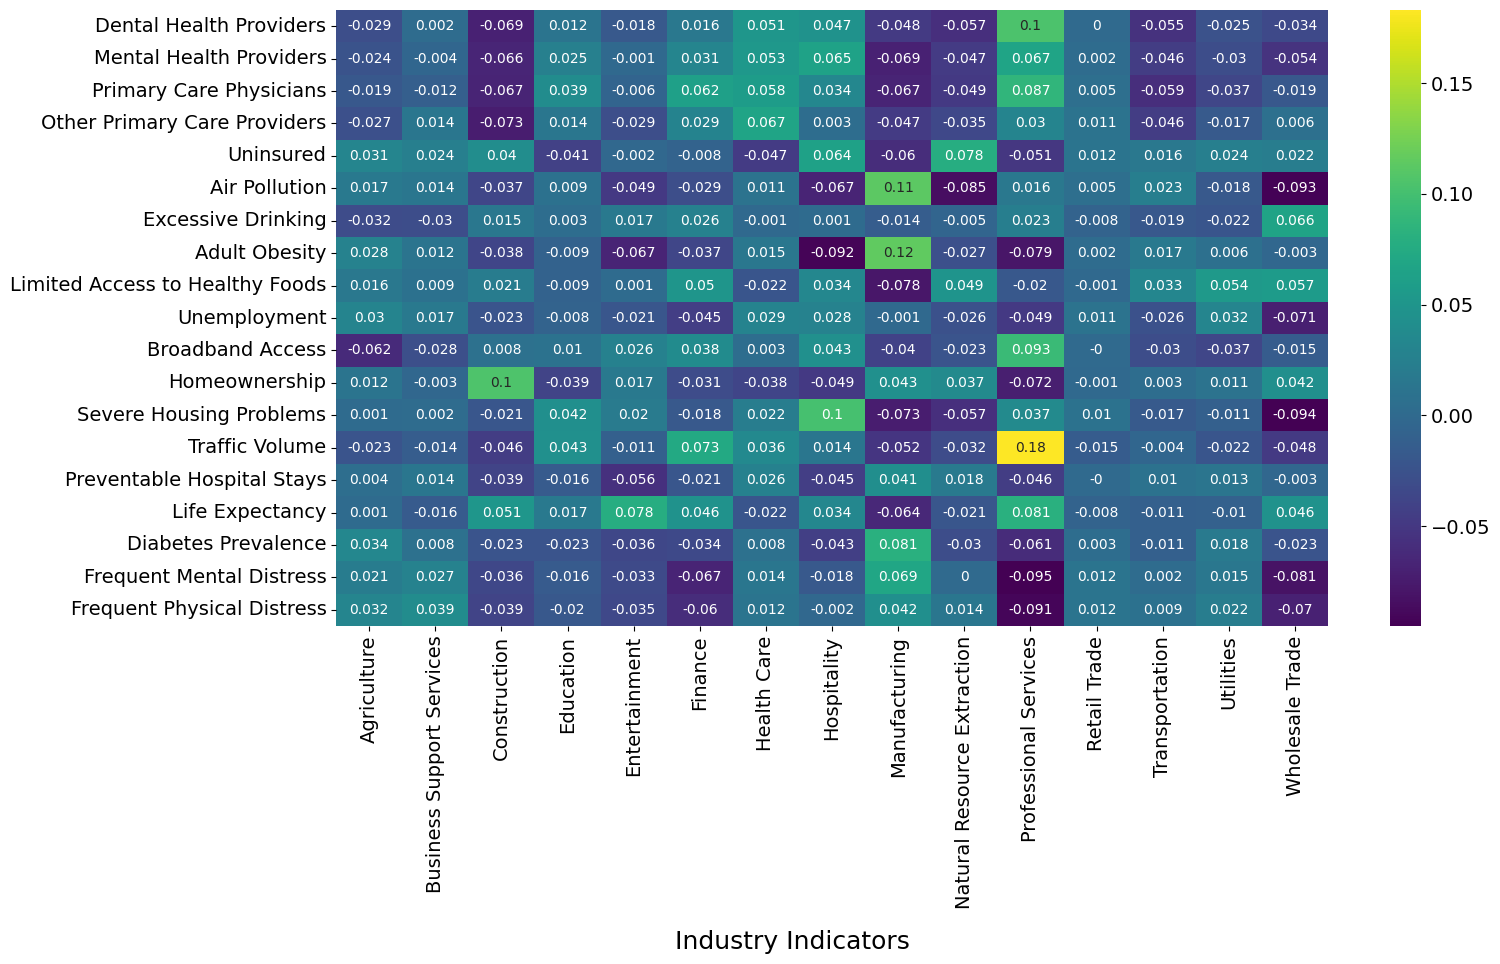

In [ ]:
# -- Generate heatmap of correlation matrix between health measures and top industries
plt.rcParams['figure.figsize'] = [16,8]
row = corr_industry_with_health_measures(raw_df, 3, county_threshold=20)
ax = sns.heatmap(
    row, 
    annot=True, 
    annot_kws={'size': SMALLEST_SIZE+2},
    cmap=PALETTE_SEQUENTIAL, 
)

fig = ax.get_figure()
fig.supxlabel('Industry Indicators', size=MEDIUM_SIZE, x= 0.41, y=-0.3)
fig.savefig('Fig3_cor_top3ind.png', bbox_inches='tight', pad_inches = 1.5)
plt.show()

We see some slight positive and negative correlations between top industries and health measures, which we explore further in our report.

## 4f. Parallel plots (for report)

Finally, we examine whether there are dominant industries with similar trends in health measures.

In [ ]:
# -- Convert metrics that are listed as percents to proper percents
for health_metric in [hm for hm in HEALTH_METRICS if hm.unit == '%']:
    raw_df[health_metric.col_name] = raw_df[health_metric.col_name] * 100

In [ ]:
# -- Slice the data frame to the health metrics we're interested in, with the given county threshold and max_rank
def slice_for_industry_health_profiles(df: DataFrame, health_metrics: list[MetricOfInterest], *, 
                                       county_threshold: Optional[int]=1, max_rank: Optional[int]=100, 
                                       use_mean: Optional[bool]=False) -> DataFrame:
    """If no county_threshold is provided, will return all industries that are in at least one county.
    If no max_rank is specified, will return all counties that have the industry as a rank less than 100 (all)
    """
    use_median = not use_mean

    sliced_df = slice_industries_threshold_on_num_counties(df, county_threshold, max_rank=max_rank)

    # Slice off metrics of interest for groupby
    cols = [m.col_name for m in health_metrics]
    cols.extend(['naics', 'Industry Description'])
    tdf = sliced_df[cols]

    if use_median:
        tdf = tdf.groupby(['naics', 'Industry Description']).median()
    
    if use_mean:
        tdf = tdf.groupby(['naics', 'Industry Description']).mean()

    return tdf.reset_index()

In [ ]:
large_label = 'Large Industries Trend'
opposite_label = 'Opposite Trend'
unique_label = 'Unique Trend'

# -- Generate averaged health profiles for industries of interest
def annotate_average(df: DataFrame, industries: list[str], faux_naics: str, description: str) -> DataFrame:
    tdf = df[df['Industry Description'].isin(industries)]
    # First two columns are metadata, no need to calculate mean
    avg_df = tdf.iloc[:, 2:].mean().to_frame().transpose()
    avg_df['naics'] = faux_naics
    avg_df['Industry Description'] = description

    # Shift columns
    cols_to_move = ['naics', 'Industry Description']
    avg_df = avg_df[cols_to_move + [col for col in avg_df.columns if col not in  cols_to_move]]

    return avg_df

# -- Add fake label for NAICS of averaged industries
def annotation_config() -> dict:
    results = dict()

    results[large_label] = {
        'naics': '0-----',
        'industries': inds_large.copy(),
    }
    results[large_label]['industries'].append('Business Support Services')

    results[opposite_label] = {
        'naics': '1-----',
        'industries': ['Education', 'Utilities'],
    }

    results[unique_label] = {
        'naics': '2-----',
        'industries': ['Entertainment', 'Agriculture']
    }

    return results

# -- Generate parallel coordinate plot for industries of interest
def make_industry_health_profile_parallel(df: DataFrame, health_metrics: list[MetricOfInterest], 
                                          *, industries_of_interest: list[str]=None, 
                                          title: Optional[str]=None) -> None:
    """
    industries_of_interest should be a list of strings that are the industry names
    """
    metric_name_to_units = {hm.name: hm.unit for hm in health_metrics}
    metrics_to_scale = ['Mental Health Providers', 'Primary Care Physicians']
    
    tdf = slice_for_industry_health_profiles(df, health_metrics, use_mean=False)

    # Annotate data frame with average trends for selected groups of industries (for report)
    for group, values_dict in annotation_config().items():
        avg = annotate_average(tdf, values_dict['industries'], values_dict['naics'], group)
        tdf = pd.concat([tdf, avg])

    # Reorder the column names to desired order for report visualization
    if industries_of_interest:
        ordered_col_names = list()
        for group, values_dict in annotation_config().items():
            # Insert the "average" column in the middle of the list of industries
            industries = values_dict['industries']
            midpoint = len(industries)//2
            industries = industries[0:midpoint] + [group] + industries[midpoint:]
            # Add them to the list
            ordered_col_names.extend(industries)
        tdf = tdf[tdf['Industry Description'].isin(ordered_col_names)]
        tdf['Industry Description'] = pd.Categorical(values=tdf['Industry Description'], 
                                                     categories=ordered_col_names,
                                                     ordered=True)
        tdf= tdf.sort_values(by='Industry Description', ascending=False)
        tdf['Industry Description'] = tdf['Industry Description'].astype('string')
        tdf = tdf.reset_index()

    # Drop unnecessary column(s)
    tdf = tdf.drop(columns='naics')

    # Rename the columns for readable health measures
    tdf = tdf.rename(columns=HEALTH_COL_TO_LABEL)

    # Add dummy column that will be used as a legend
    tdf['dummy'] = tdf.index

    # Annotate large industries with asterisk - for visualization
    for value in tdf['Industry Description']:
        if value in inds_large:
            tdf.loc[tdf['Industry Description']==value, 'Industry Description'] = f'{value}*'

    # Initialize the dimensions to be displayed with our faux legend
    dimensions = [
        {
            'label': 'Industry Description',
            'values': tdf['dummy'],
            'tickvals': tdf['dummy'],
            'ticktext': tdf['Industry Description'],
        }
    ]

    # Now add the measures, which are sandwiched between the first, second, & last columns
    for idx, col_name in enumerate(tdf.columns[2:-1]): 
        label = col_name
        if metric_name_to_units[col_name] == '%':
            label = f'{col_name} %'

        values = tdf[col_name].to_numpy()
        if col_name in metrics_to_scale:
            values = values * 100000    
        dimensions.append(
            {
                'label': label,
                'values': values,
            }
        )

    # -- Add discrete color scale
    # Get colors from tab20 in hexadecimal form
    color_list = [colors.to_hex(plt.cm.tab20(i)) for i in range(20)]

    # Assign colors to each portion of scale - ranges from 0 to 1
    discrete_color_scale = []
    color_list_len = len(color_list)-1
    for i, curr_color in enumerate(color_list):
        tuple1=[i/color_list_len,curr_color]
        discrete_color_scale.append(tuple1)

    # Color lines using discrete color scale - one for each industry
    fig = go.Figure(data=go.Parcoords(
        line={
            'color': tdf['dummy'],
            'colorscale': discrete_color_scale
        },
        dimensions=dimensions
    ))

    # Add title to plot, if specified
    if title:
        fig.update_layout(
            title=title,
        )

    # Adjust figure formatting
    fig.update_layout(
        font={'family': 'Arial', 'size': 14},
        bargap=0.9,
        width=len(tdf.columns) * 200,
        margin= {'l': 225},
    )

    return fig

In [ ]:
# -- Selected health measures for health profile and groups of industries to explore

# Selected health metrics to explore
health_metrics_profile = [
    METRIC_PCPS,
    METRIC_MENTAL_PROVIDERS,
    METRIC_UNINSURED,
    METRIC_FREQ_PHYSICAL_DISTRESS,
    METRIC_FREQ_MENTAL_DISTRESS,   
    METRIC_ACCESS_HEALTHY_FOODS,
    METRIC_ADULT_OBESITY,
    METRIC_HOUSING_PROBLEMS,
]

# Set of top 10 largest industries
inds_top10 = [
'Retail Trade',
'Health Care',
'Construction',
'Hospitality',
'Professional Services',
'Transportation',
'Wholesale Trade',
'Finance',
'Manufacturing',
'Natural Resouce Extraction'
]

# Set of top 5 largest industries
inds_large = [
'Retail Trade',
'Health Care',
'Manufacturing',
'Hospitality',
'Construction'
]

# Set of 5 smallest industries
inds_small = [
'Business Support Services',
'Education',
'Utilities',
'Entertainment',
'Agriculture'
]

# Combine largest and smallest industries, used in final explorations
top_bot = inds_large + inds_small

In [ ]:
# -- Parallel coordinates plot of all industries for selected health measures
make_industry_health_profile_parallel(raw_df, health_metrics_profile)

In [ ]:
# -- Parallel coordinates plot of top 10 largest industries for selected health measures
make_industry_health_profile_parallel(raw_df, health_metrics_profile, industries_of_interest= inds_top10)

In [ ]:
# -- Parallel coordinates plot of largest and smallest industries for selected health measures
make_industry_health_profile_parallel(raw_df, health_metrics_profile, industries_of_interest= top_bot)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=935c12df-95fc-47b5-a033-2935b9193bd3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>